# ◈ 데이터 분석 준비

## 1) Colab 환경 설정

In [ ]:
# 시각화 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 트리맵
!pip install squarify

# 요인분석
!pip install pingouin factor_analyzer

# 연관분석
!pip install -U apyori mlxtend

## 2) 필수 라이브러리 로드

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from patsy import demo_data, dmatrix, dmatrices

## 3) 글로벌 환경 설정

In [ ]:
#%precision 3 # np 정확도를 소숫점 3자리로 고정
%matplotlib inline
sns.set_theme()

# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

sns_color = sns.color_palette('pastel')
plt_line = ['-', '--', ':', '-.']

## 4) 분석 데이터 로드

In [ ]:
mtcars = pd.read_csv('https://github.com/ksky1313/ADP/raw/main/data/mtcars.csv')
mtcars.drop(columns=mtcars.columns[0], inplace=True)
titanic = pd.read_csv('https://github.com/ksky1313/ADP/raw/main/data/titanic.csv', encoding='utf-8')
titanic.drop(columns=titanic.columns[0], inplace=True)

df = mtcars

# ◈ 데이터 셋 확인

## 1) 변수 확인

### 가) ADP EDA 실행

In [ ]:
def adp_eda(df, y, round=3):
    rtn = pd.DataFrame(
        data={
            'dtypes':df.dtypes.values,
            'count':df.count().values,
            'na':df.isna().sum().values,
            'nunique':df.nunique().values,
        },
        index = df.columns
    )

    rtn['na%'] = np.round(rtn['na']/df.shape[0]*100, round)
    for feature in rtn.index:
        rtn.loc[feature, 'unique'] = str(list(df[feature].unique()))
        
        tmp = df.loc[df[feature].notna(), :]
        if rtn.loc[feature, 'dtypes'] == 'object':
            rtn.loc[feature, 'corr'] = np.round(stats.spearmanr(tmp[y], tmp[feature])[0], round)
            rtn.loc[feature, 'min'] = -np.inf
            rtn.loc[feature, 'max'] = -np.inf
            rtn.loc[feature, 'mean'] = -np.inf
            
            rtn.loc[feature, 'l_outlier'] = 0
            rtn.loc[feature, 'u_outlier'] = 0
            rtn.loc[feature, 'l_limit'] = -np.inf
            rtn.loc[feature, 'u_limit'] = -np.inf
        else:
            rtn.loc[feature, 'corr'] = np.round(stats.pearsonr(tmp[y], tmp[feature])[0], round)
            rtn.loc[feature, 'min'] = np.round(df[feature].min(), round)
            rtn.loc[feature, 'max'] = np.round(df[feature].max(), round)
            rtn.loc[feature, 'mean'] = np.round(df[feature].mean(), round)
            
            q3, q1 = df[feature].quantile([.75, .25])
            UL, LL = q3+1.5*(q3-q1), q1-1.5*(q3-q1)
            rtn.loc[feature, 'l_outlier'] = df[df[feature] < LL][feature].count()
            rtn.loc[feature, 'u_outlier'] = df[df[feature] > UL][feature].count()
            rtn.loc[feature, 'l_limit'] = np.round(LL, round)
            rtn.loc[feature, 'u_limit'] = np.round(UL, round)
        
    rtn.l_outlier = rtn.l_outlier.astype(int)
    rtn.u_outlier = rtn.u_outlier.astype(int)
    return rtn[['dtypes', 'corr', 'count', 'mean', 'min', 'max', 'na', 'na%', 'l_limit', 'u_limit', 'l_outlier', 'u_outlier', 'nunique', 'unique']]

In [ ]:
df_eda = adp_eda(df, 'Survived', round=2)
df_eda

### 나) Pandas Profile Report

In [ ]:
# Pandas Profile Report 설치
!pip install -U pandas-profiling

In [ ]:
# HTML 파일에 저장
import pandas_profiling
profile_report = df.profile_report(html={"style": {"full_width": True}})
profile_report.to_file("profile_reort.html")

## 2) 변수 통계량 확인

### 가) 분산/표준편차

In [ ]:
print(f'표본분산 : {df.cyl.var(ddof=0)}')
print(f'불편분산 : {df.cyl.var(ddof=1)}')
print(f'공분산 : {np.cov(df.cyl, df.disp, ddof=0)}')
print(f'Pandas 표준편차 : {df.cyl.std(ddof=1)}') # default ddof = 1
print(f'Numpy 표준편차 : {np.std(df.cyl, ddof=0)}') # default ddof = 0

표본분산 : 3.08984375
불편분산 : 3.189516129032258
공분산 : [[3.08984375e+00 1.93420898e+02]
 [1.93420898e+02 1.48807748e+04]]
Pandas 표준편차 : 1.7859216469465444
Numpy 표준편차 : 1.757795138803154


### 나) 범위/빈도

> 사분위수

In [ ]:
print(f'Pandas 사분위수 : {df.cyl.quantile([.25, .75])}')
print(f'Numpy 사분위수 : {np.percentile(df.cyl, [25, 75])}')

Pandas 사분위수 : 0.25    4.0
0.75    8.0
Name: cyl, dtype: float64
Numpy 사분위수 : [4. 8.]


> 히스토그램

In [ ]:
np.histogram(df.cyl, bins=10, range=(0,10), density=False)

(array([ 0,  0,  0,  0, 11,  0,  7,  0, 14,  0]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

> 최빈값

In [ ]:
# 최빈값
df.gear.mode()

0    3
dtype: int64

## 3) 변수간 관계 확인

### 가) 연속형 - 연속형 변수

In [ ]:
# 상관 분석
df.corrwith(df.mpg).sort_values()

wt     -0.867659
cyl    -0.852162
disp   -0.847551
hp     -0.776168
carb   -0.550925
qsec    0.418684
gear    0.480285
am      0.599832
vs      0.664039
drat    0.681172
mpg     1.000000
dtype: float64

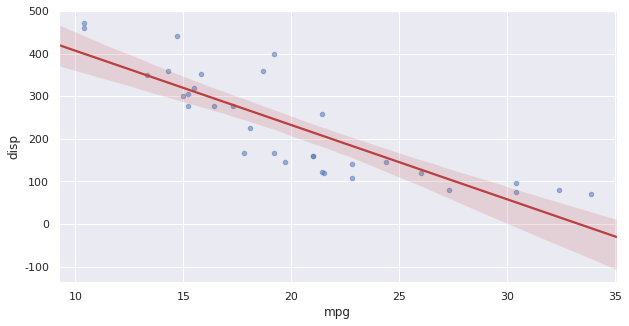

In [ ]:
# 상관 관계 시각화
sns.regplot(
    data = df,
    x = 'mpg',
    y = 'disp',
    # marker ='*', # 마커 : 'o', '*', '+'
    # color = 'green',
    scatter_kws=dict(alpha=0.5, s=20),
    line_kws=dict(color='#bb3f3f'),
    fit_reg = True,
    truncate = False, # 좌우측 여백 유무
    # x_estimator = np.mean, # X 데이터를 CI로 묶어서 표시
    # ci = None, # Confidence Interval : 'sd', 0~100, None
    );

### 나) 범주형 - 범주형 변수

[chi2_contingency] (H0)두 변수는 독립적이다: False, pvalue = 0.0012


SpearmanrResult(correlation=-0.5643104747017164, pvalue=0.0007678208835711609)

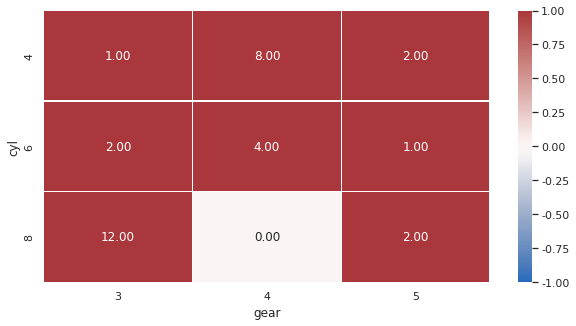

In [ ]:
# Contingency Table 생성 & 시각화
df_contingency = pd.crosstab(
    df['cyl'],
    df['gear']
    )

sns.heatmap(
    data = df_contingency,
    annot = True,
    vmax = 1,
    vmin = -1,
    cmap = 'vlag', # 'RdYlBu_r', 'vlag', 'coolwarm'
    linewidths=.5,
    fmt='.2f',
    );

# 카이제곱 검정
chi, pvalue, dof, expected = stats.chi2_contingency(df_contingency)
print(f'[chi2_contingency] (H0)두 변수는 독립적이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 스피어만 상관분석
stats.spearmanr(df.cyl, df.gear)

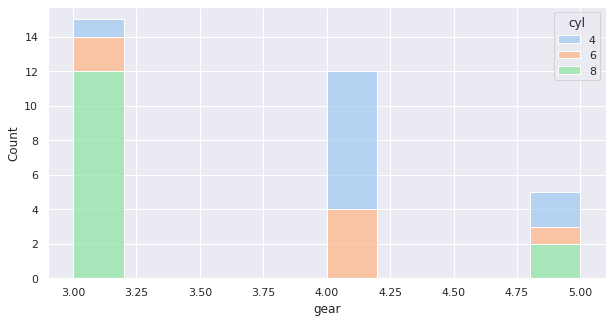

In [ ]:
# 누적 막대 그래프 시각화
sns.histplot(
    data = df,
    x = 'gear',
    # y = 'Temp',
    hue = 'cyl',
    palette = 'pastel',  # 'vlag', 'pastel', 'Set2'
    alpha = 0.7,
    # color = '#bb3f3f',
    # legend = False, # 범례 : 'auto', 'brief', 'full', False
    # linewidth = 2,
    bins = 10,
    # kde = True, # KDE 곡선 표시 여부
    multiple = 'stack', # 적층 : 'layer', 'stack', 'fill', 'dodge'
    stat = 'count', # 통계 : 'count', 'frequency', 'percent', 'density', 'proportion'
    );

### 다) 범주형 - 연속형 변수

> 2개 범주 - T검정

In [ ]:
# 등분산 검정
stat, pvalue = stats.levene(df.query('am==0')['mpg'], df.query('am==1')['mpg'])
print(f'[levene] (H0)등분산이다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

# 독립표본 T검정 실시
stat, pvalue = stats.ttest_ind(df.query('am==0')['mpg'], df.query('am==1')['mpg'], equal_var=False)
print(f'[ttest_ind] (H0)평균에 차이가 없다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

[levene] (H0)등분산이다: False, pvalue = 0.0496
[ttest_ind] (H0)평균에 차이가 없다: False, pvalue = 0.0014


> 3개 범주 이상 - ANOVA

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('mpg ~ C(cyl)', df).fit()
am = anova_lm(model, typ=3)

pvalue = am.loc['C(cyl)', 'PR(>F)']
print(f'[shapiro] (H0)평균은 같다: {pvalue>0.05}, pvalue = {pvalue:.4f}')

print(am)

[shapiro] (H0)평균은 같다: False, pvalue = 0.0000
                sum_sq    df           F        PR(>F)
Intercept  7820.444545   1.0  752.807995  2.688358e-22
C(cyl)      824.784590   2.0   39.697515  4.978919e-09
Residual    301.262597  29.0         NaN           NaN


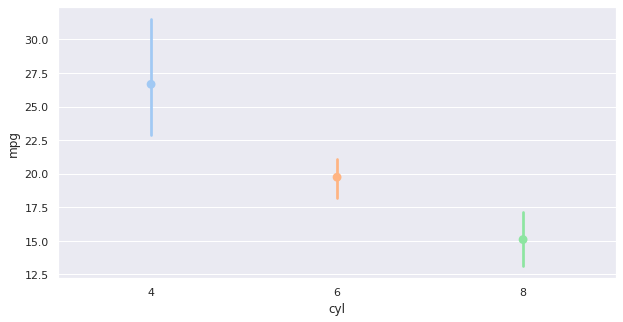

In [ ]:
# 범주별 평균 시각화
sns.pointplot(
    data = df,
    x = 'cyl',
    y = 'mpg',
    # hue = 'sex', 
    palette = 'pastel',  # 'vlag', 'pastel', 'Set2'
    # alpha = 0.7,            
    # color = '#bb3f3f',      
    # capsize = .2, # 상하단 바
    # join = False, # 연결선
    dodge = True, # 그룹간 간격
    ci = 100, # Confidence Interval : 'sd', 0~100, None
    );

# ◈ 결측값 처리
1. **평균값으로 대체** (Mean Imputation)
  - 변수의 평균값이 변하지 않지만 많은 단점 초래 
2. **새로운 값으로 대체** (Substitution)
3. **Hot deck imputation**
  - 다른 변수중 비슷한 데이터 하나를 랜덤 샘플링
  - 결측값이 존재하는 값의 범위가 한정되어 있을 때 이점
4. **Cold deck imputation**
  - Hot deck과 유사하게 다른 변수의 비슷한 데이터를 골라 그 값으로 대체
  - 하지만 랜덤 샘플링하는 것이 아니라 특정 규칙을 적용(예를 들면, k번째 샘플의 값을 취해온다는 등)
5. **Regression imputation**
  - 결측치를 채우고자 하는 변수를 target으로 삼아 regression task를 진행
  - 데이터 내의 다른 변수를 기반으로 결측치를 예측하므로 변수 간 관계 유지
  - 예측치 간 variability는 보존하지 못하는 단점 존재
6. **Stochastic regression imputation**
  - regression 방법에 random residual value를 더해서 결측치를 대체
7. **Interpolation and extrapolation** (보간법, 보외법)
  - 같은 대상으로부터 얻은 다른 관측치로부터 결측치 부분을 추정
  - 어린이 성장과정 추적에서 얻은 키 데이터 등 특별한 경우만 가능

## 1) 결측값 확인

In [ ]:
df = titanic

# 결측치 확인
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

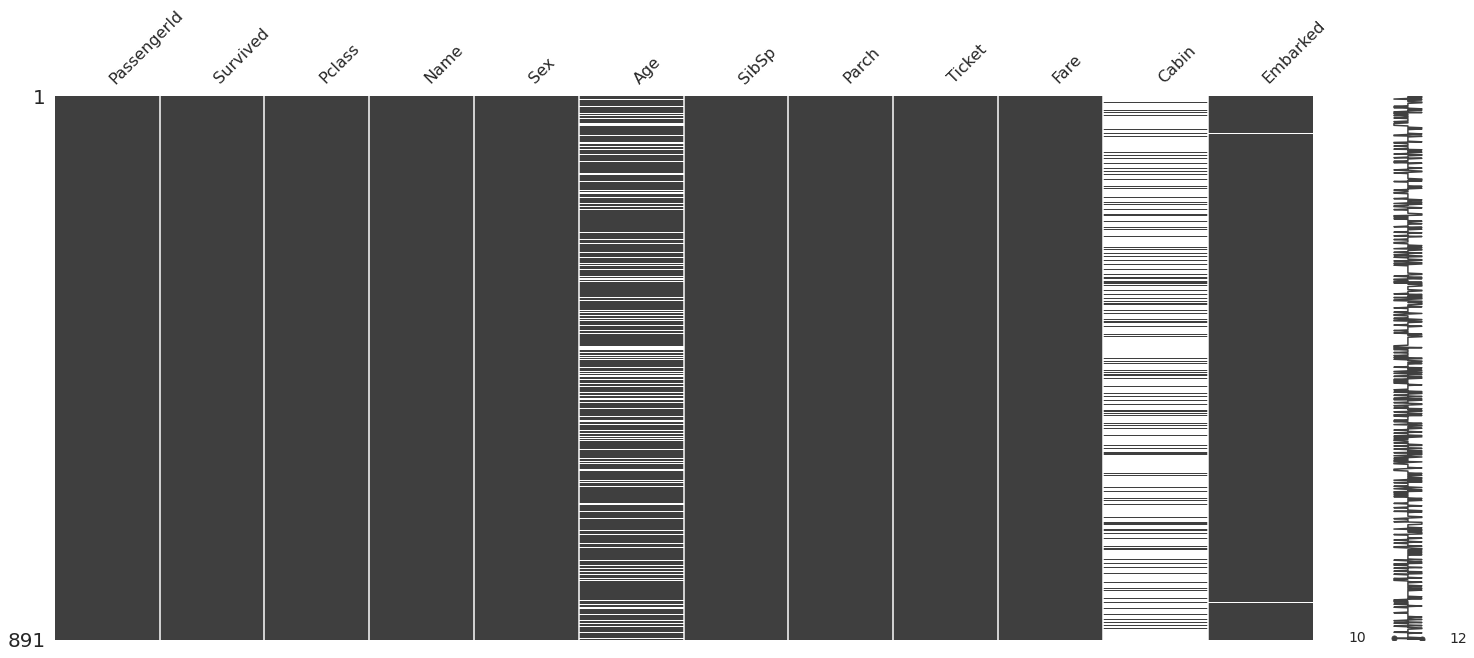

In [ ]:
# 결측치 시각화
msno.matrix(df);

## 2) 결측값 삭제
- 70% 이상의 임계치를 정하고 결측치가 존재하는 행/열을 삭제
- 데이터 손실이 발생하므로 선호되지 않음

In [ ]:
# 결측값이 하나라도 있는 행 삭제
df_notna = df.dropna(axis=0, how='any', inplace=False)

## 3) 결측값 대체
- Univariate
    - SimpleImputer
- Multivariate
    - IterativeImputer
    - Regression Imputation : 회귀분석을 통해 변수 예측, 변수간 관계가 
        - Deterministic Imputation : 예측된 값으로 대체, 변수간 상관관계 과대평가 유발할 수 있음
        - Stochastic Imputation : 예측값에 임의 오차항 추가, 변수간 상관관계를 보다 적절하게 재현
    - KNNImputation : 이상치에 민감

### 가) pandas fillna, interpolate 이용

In [ ]:
# 지정 값으로 치환
df.eval('Age_fillna = Age', inplace=True)
df['Age_fillna'].fillna(df.Age.median(), inplace=True)

# 앞 행 값으로 치환
df.eval('Age_ffill = Age', inplace=True)
df['Age_ffill'].fillna(method='ffill', inplace=True)

# 뒤쪽 행 값으로 치환
df.eval('Age_bbill = Age', inplace=True)
df['Age_bbill'].fillna(method='bfill', inplace=True)

# 앞/뒤 평균 값으로 치환
df.eval('Age_interpolate = Age', inplace=True)
df['Age_interpolate'].interpolate(inplace=True)

df[['Age', 'Age_fillna', 'Age_ffill', 'Age_bbill', 'Age_interpolate']].head(20)

,Age,Age_fillna,Age_ffill,Age_bbill,Age_interpolate
0,22.0,22.0,22.0,22.0,22.0
1,38.0,38.0,38.0,38.0,38.0
2,26.0,26.0,26.0,26.0,26.0
3,35.0,35.0,35.0,35.0,35.0
4,35.0,35.0,35.0,35.0,35.0
5,NaN,28.0,35.0,54.0,44.5
6,54.0,54.0,54.0,54.0,54.0
7,2.0,2.0,2.0,2.0,2.0
8,27.0,27.0,27.0,27.0,27.0
9,14.0,14.0,14.0,14.0,14.0


### 나) SimpltImputer 이용
- strategy : 'mean','median', 'most_frequent', 'constant'
  - constant로 지정값으로 대체할 때는 fill_value를 지정해야 함

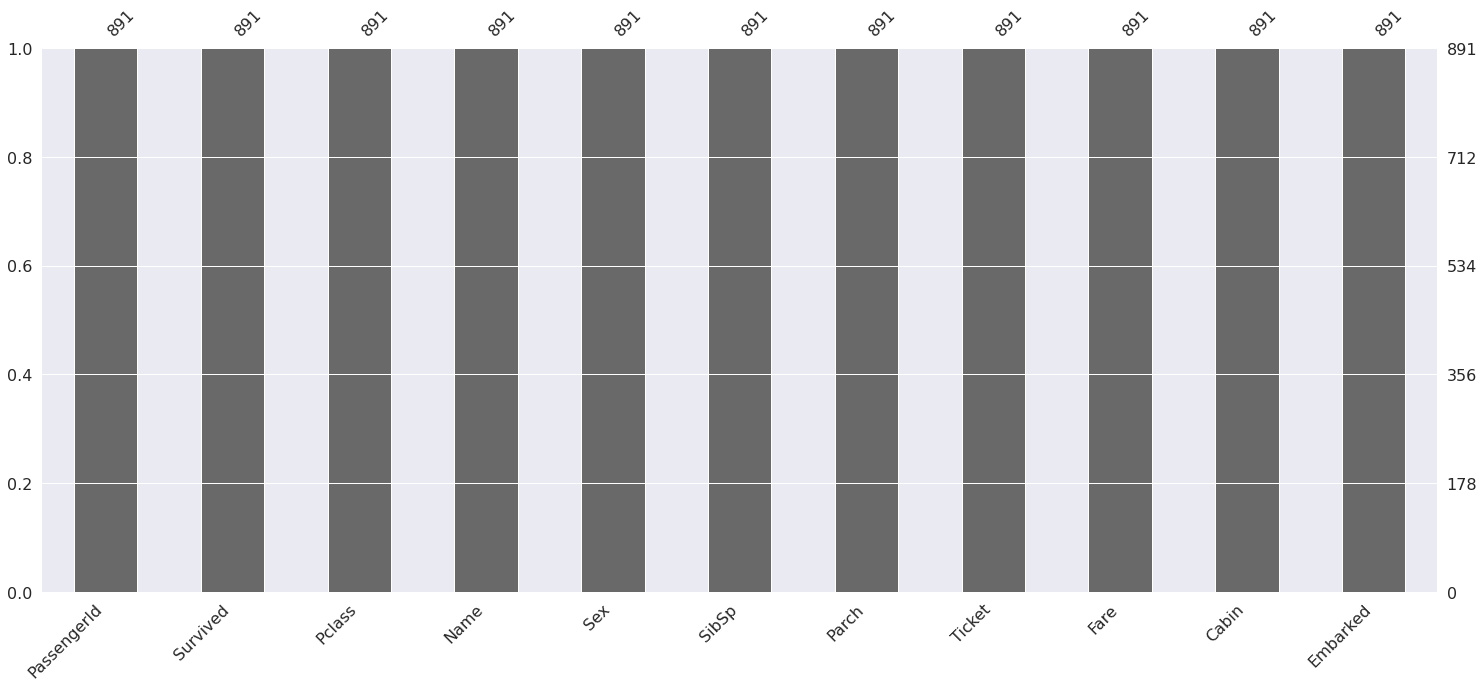

In [ ]:
from sklearn.impute import SimpleImputer

# 숫자형 변수 medaian으로 대체
df['Age'] = SimpleImputer(strategy='median').fit_transform(df[['Age']])

# 범주형 변수 최빈값 대체
df['Cabin'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Cabin']])
# df['Cabin'] = SimpleImputer(strategy='constant', fill_value='missing').fit_transform(df[['Cabin']])
df['Embarked'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Embarked']])

# 결측치 시각화
df.drop(columns=['Age', 'Age_fillna', 'Age_ffill', 'Age_bbill', 'Age_interpolate'], inplace=True)
msno.bar(df);

# ◈ 이상값 처리

## 1) 이상값 확인

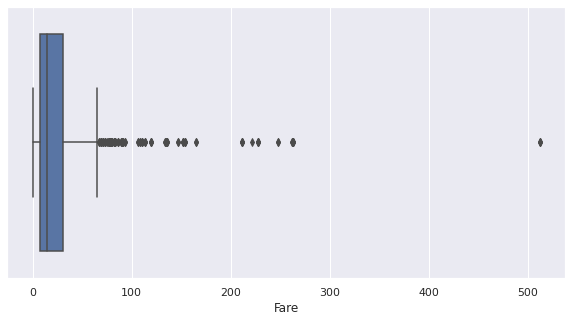

In [ ]:
# 이상값 시각화
sns.boxplot(
    data = df,
    x = 'Fare'
);

## 2) 이상값 처리
- 숫자형 변수 : 상한값으로 대체하거나 Lot Transform

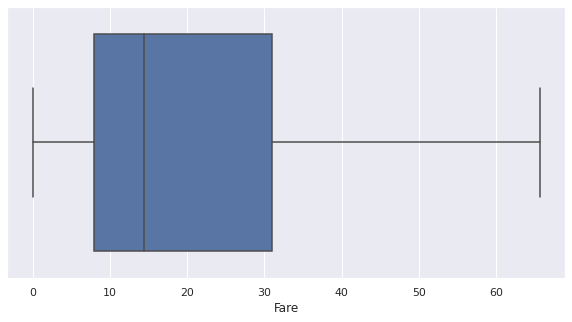

In [ ]:
# ESD 계산
q1, q3 = df['Fare'].quantile([.25, .75])
LL, UL = q1-(q3-q1)*1.5, q3+(q3-q1)*1.5

# 이상값을 상한으로 대체
df.Fare = np.where(df.Fare > UL, UL, df.Fare)

# 이상값 시각화
sns.boxplot(
    data = df,
    x = 'Fare'
);

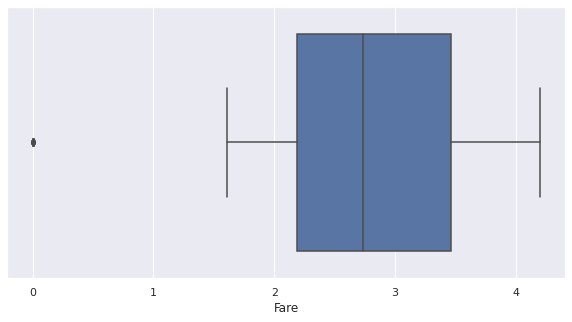

In [ ]:
# Log Transform
if df['Fare'].min() > 0:
    df['Fare'] = (df['Fare']+1).transform(np.log)
else:
    df['Fare'] = (df['Fare']-df['Fare'].min()+1).transform(np.log)

# 이상값 시각화
sns.boxplot(
    data = df,
    x = 'Fare'
);

## 3) 범주형 변수

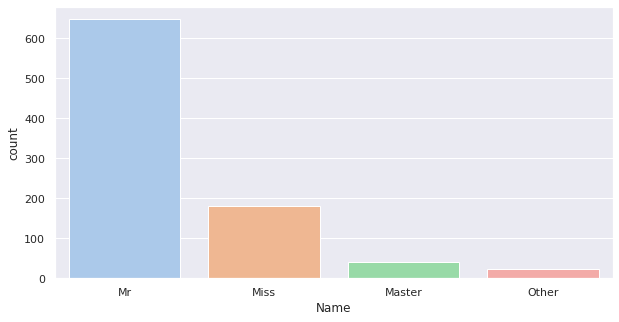

In [ ]:
# binning
condlist = [
    df['Name'].str.contains('Mr.'),
    df['Name'].str.contains('Miss.'),
    df['Name'].str.contains('Mrs.'),
    df['Name'].str.contains('Master.')
    ]

choicelist = ['Mr', 'Miss', 'Mrs', 'Master']

df['Name'] = np.select(
    condlist = condlist, 
    choicelist = choicelist, 
    default = 'Other')

# 변환 결과 확인
sns.countplot(
    data = df,
    x = 'Name',
    # y = 'species',
    # hue = 'sex',
    palette = 'pastel',  # 'vlag', 'pastel', 'Set2'
    # alpha = 0.7,
    # color = '#bb3f3f',
    linewidth = 1,
    );

# ◈ Feature Engineering

## 1) 변수 변환
- 범주형, 숫자형 컬럼 범주화 또는 encoding
- 날짜형 데이터 변환(년, 월, 일 분리)

### 가) Label Encoding
- 카테고리 컬럼의 데이터를 숫자형으로 변환
- 회귀분석에서는 숫자의 크고 작음으로 인해 가중치가 더 부여될 수 있으므로 적용하지 않아야 함

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

df = pd.DataFrame(data = demo_data('group', 'color', 'size', min_rows=100))

enc = OrdinalEncoder()
df['group_enc'] = enc.fit_transform(df[['color']])
df.head()

,color,group,size,group_enc
0,color1,group1,1.764052,0.0
1,color1,group2,0.400157,0.0
2,color2,group1,0.978738,1.0
3,color2,group2,2.240893,1.0
4,color1,group1,1.867558,0.0


> 인코딩 클래스 확인

In [ ]:
enc.classes_

array(['color1', 'color2'], dtype=object)

### 나) Binarizer
- threshold 보다 크면 1, 적으면 0으로 변환 

In [ ]:
from sklearn.preprocessing import Binarizer

df['size_bin'] = Binarizer(threshold=1).fit_transform(df[['size']])
df.head()

,color,group,size,group_enc,size_bin
0,color1,group1,1.764052,0,1.0
1,color1,group2,0.400157,0,0.0
2,color2,group1,0.978738,1,0.0
3,color2,group2,2.240893,1,1.0
4,color1,group1,1.867558,0,1.0


### 다) 텍스트 추출/변환

> 숫자 제거

In [ ]:
import re

line = 'CA 2144'
re.sub('[0-9 ]', '', line)

## 2) 표준화 및 정규화
- RBF SVM, 선형회귀, 로지스틱 회귀는 가우시안 분포를 가정하므로 표준화(Standard Scaler) 적용하는 것이 예측 성능 향상에 중요함
- 종류
  - MinMaxScaler : 최소 최대값을 기준으로 0~1로 정규화
    - 모든 이상값의 존재에 대해 매우 민감
  - StandardScaler : 평균 0, 분산 1로 표준화
    - 이상치가 존재하면 평균이 치우쳐 있으므로 변수의 균형을 보장하지 못함
  - RobustScaler : 중위수와 사분위수를 이용해 스케일링
    - 소수의 이상치에 영향을 받지 않으나 MinMaxScaler, StandardScler 보다 값의 범위가 넓다
    - 이상치 자체는 변환된 데이터에 여전히 존재
  - QuantileTransformer : 확률밀도함수가 균일하거나 가우시안 분포가 되도록 0~1 범위로 비선형 변환
    - RobustScaler와 달리 이상치가 유지되지 않고 0~1범위 분포에 매핑되어 축소
    - 파라미터 지정을 통해 균일 또는 가우시안분로를 설정 가능
    - 균일(output_distribution='uniform'), 가우시안 분포(output_distribution='normal')
  - PowerTransformer : 가우시안 분포가 되도록 제로 평균 분산 정규화 적용해 데이터를 변환
    - 데이터에 양수만 있는 경우 : method = 'box-cox'
    - 데이터에 음수가 포함된 경우 : method = 'yeo-johnson'

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer

df = pd.DataFrame(data=[1, 2, 3, 4, 3, 4, 5, 1000], columns=['x'])

df['MinMaxScaler'] = MinMaxScaler().fit_transform(df[['x']])
df['StandardScaler'] = StandardScaler().fit_transform(df[['x']])
df['RobustScaler'] = RobustScaler().fit_transform(df[['x']])
df['QuantileTrans_uniform'] = QuantileTransformer(output_distribution="uniform").fit_transform(df[['x']])
df['QuantileTrans_normal'] = QuantileTransformer(output_distribution="normal").fit_transform(df[['x']])
df['PowerTransformer_yeo'] = PowerTransformer(method="yeo-johnson").fit_transform(df[['x']])
df['PowerTransformer_box'] = PowerTransformer(method="box-cox").fit_transform(df[['x']])

df

,x,MinMaxScaler,StandardScaler,RobustScaler,QuantileTrans_uniform,QuantileTrans_normal,PowerTransformer_yeo,PowerTransformer_box
0,1,0.000000,-0.384462,-1.666667,0.000000,-5.199338,-1.669182,-1.809227
1,2,0.001001,-0.381429,-1.000000,0.142857,-1.067571,-0.721468,-0.649935
2,3,0.002002,-0.378395,-0.333333,0.357143,-0.366106,-0.195337,-0.136714
3,4,0.003003,-0.375362,0.333333,0.642857,0.366106,0.145455,0.169091
4,3,0.002002,-0.378395,-0.333333,0.357143,-0.366106,-0.195337,-0.136714
5,4,0.003003,-0.375362,0.333333,0.642857,0.366106,0.145455,0.169091
6,5,0.004004,-0.372329,1.000000,0.857143,1.067571,0.386834,0.377716
7,1000,1.000000,2.645735,664.333333,1.000000,5.199338,2.103579,2.016692


## 3) 더미 변수화
- Full Rank : 특정 변수에 존재하는 모든 범주값으로 더미변수를 만든다.
- Reduced Rank : 특정 변수에 존재하는 기준값은 항상 1로 두고, 나머지를 더미변수로 만든다.
  - Reduced Rank가 필요한 이유는 변수간에 독립성을 보장하기 위해서임
  - 변수값이 A, B인 경우 Full Rank로 더미변수를 생성하면 A, B 두개의 컬럼이 생성되는데 B값이 결정되면 A값이 확정되므로 2개의 더미변수를 모두 사용하면 다중공선성이 발생함

### 가) Full Rank 더미 변수화

In [ ]:
import pandas as pd
import numpy as np
from patsy import demo_data, dmatrix

df = pd.DataFrame(data=[['a', 'c'], ['b', 'e'], ['a', 'c'], ['b', np.NAN], ['a', 'd'], ['b', 'e']], columns=['x1', 'x2'])

> Pandas - get_dummies

In [ ]:
pd.get_dummies(
    data = df['x2'], 
    prefix = 'x2', 
    dummy_na = False, 
    drop_first = False)

,x2_c,x2_d,x2_e
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,0
4,0,1,0
5,0,0,1


> patsy - dmatrix

In [ ]:
dmatrix('x2+0', df, return_type='dataframe')

,x2[c],x2[d],x2[e]
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
4,0.0,1.0,0.0
5,0.0,0.0,1.0


> sklearn - OneHotEncoder

In [ ]:
# NAN 제거 못하고 array 타입으로 리턴
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(drop=None).fit_transform(df[['x2']]).toarray()

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

### 나) Reduced Rank 더미 변수화

> Pandas - get_dummies

In [ ]:
# 축소 Rank 방식
pd.get_dummies(
    data = df['x2'], 
    prefix = 'x2', 
    dummy_na = False, 
    drop_first = True) # True로 설정하여 1개 컬럼을 삭제

,x2_d,x2_e
0,0,0
1,0,1
2,0,0
3,0,0
4,1,0
5,0,1


> patsy - dmatrix

In [ ]:
# 축소 Rank 방식
dmatrix('x2', df, return_type='dataframe') # '+0'을 포함하지 않으면 됨

,Intercept,x2[T.d],x2[T.e]
0,1.0,0.0,0.0
1,1.0,0.0,1.0
2,1.0,0.0,0.0
4,1.0,1.0,0.0
5,1.0,0.0,1.0


> sklearn - OneHotEncoder

In [ ]:
# NAN 제거 못하고 array 타입으로 리턴
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(drop='first').fit_transform(df[['x2']]).toarray()

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

### 다) 두개 이상 범주형 변수 포함
- 통합 축소형 또는 상호작용 방식으로 더미변수화

In [ ]:
# 통합 축소형 - Pandas get_dummies 이용
pd.get_dummies(
    data = df, 
    dummy_na = False, 
    drop_first = True)

,x1_b,x2_d,x2_e
0,0,0,0
1,1,0,1
2,0,0,0
3,1,0,0
4,0,1,0
5,1,0,1


In [ ]:
# 통합 축소형 - patsy dmatrix 이용
dmatrix('x1+x2', df, return_type='dataframe')

,Intercept,x1[T.b],x2[T.d],x2[T.e]
0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0
5,1.0,1.0,0.0,1.0


In [ ]:
# 상호 작용형
dmatrix('x1:x2', df, return_type='dataframe')

,Intercept,x2[T.d],x2[T.e],x1[T.b]:x2[c],x1[T.b]:x2[d],x1[T.b]:x2[e]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,1.0


## 4) 차원 축소

| 주성분분석 | 요인분석 |
| --- | --- |
| 관찰기술(요인분석 유형) | 모델링 기술 |
| 최대 분산양 설명 | 데이터의 공분산을 설명 |
| 관측된 변수의 선형 조합 | 미관측 변수/요인 선형조합 |
| 구성요소 해석 불가 | 레이블링 및 해석 가능 |
| 차원 축소법 | 잠재변수 방법 |

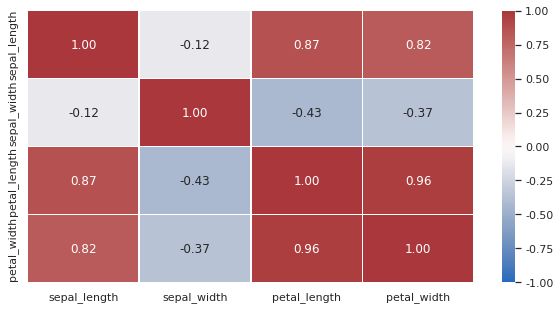

In [ ]:
# 연속형 변수간 상관관계 분석
df = sns.load_dataset('iris').iloc[:,:-1]
sns.heatmap(
    data = df.corr(),
    annot = True,
    vmax = 1,
    vmin = -1,
    cmap = 'vlag', # 'RdYlBu_r', 'vlag', 'coolwarm'
    linewidths=.5,
    fmt='.2f',
    );

### 가) 주성분분석
- 주성분-변수 관계 : pca.components_.T
- 주성분 설명력 : pca.explained_variance_ratio_

In [ ]:
from sklearn.decomposition import PCA

# 최대 갯수로 PCA 실행
ncomp = min(df.shape[0], df.shape[1])
pca = PCA(n_components = ncomp)
pca.fit(df)

# Loadings : 각 변수와 주성분간의 관계
loadings = pd.DataFrame(
    data=pca.components_.T, 
    index=df.columns,
    columns=[ 'pca_'+ str(i+1) for i in range(df.shape[1]) ]
    )

# Cumulative Explained Value : 주성분의 설명력
cev = np.cumsum(pca.explained_variance_ratio_)
cev

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

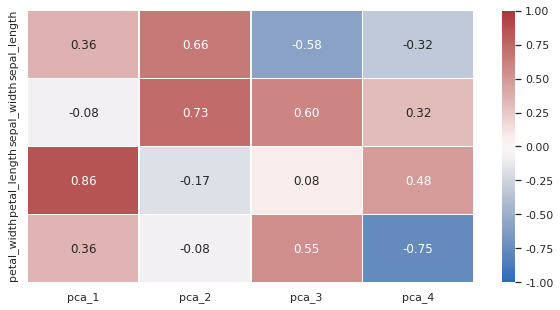

In [ ]:
sns.heatmap(
    data = loadings,
    annot = True,
    vmax = 1,
    vmin = -1,
    cmap = 'vlag', # 'RdYlBu_r', 'vlag', 'coolwarm'
    linewidths=.5,
    fmt='.2f',
    );

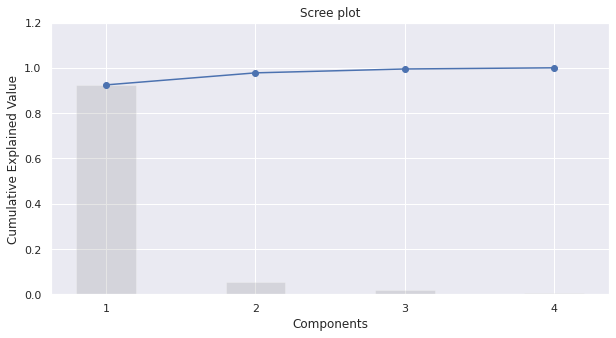

In [ ]:
x = range(1, ncomp+1)
y = pca.explained_variance_ratio_ 
s = cev

plt.title('Scree plot'.format(ncomp))
plt.ylim(0,1.2)
plt.xticks(x)
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Value')

plt.bar(x, y, color='grey', width=0.4, alpha=0.2)
plt.plot(x, s, 'bo-')

plt.show()

In [ ]:
# 주성분 갯수를 결정하고 최종 주성분 분석을 수행 후 결과 저장
pca = PCA(n_components = 2)
pca_comp = pca.fit_transform(df)

### 나) 요인분석

> 요인분석 적성성 평가
- bartlett: 관측 변수들의 상호 연관성 확인
- kmo : 관측 변수와 전체 모형의 적합성 결정(0~1 사이)
  - 0.6 미만이면 부적절, 0.8 이상이면 우수

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Bartlett 검정
stat, pvalue = calculate_bartlett_sphericity(df)
print('H0 : 상관행렬이 항등행렬(변수간 관련이 없음) : {}'.format(pvalue > 0.05))

H0 : 상관행렬이 항등행렬(변수간 관련이 없음) : False


In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo

# Kaiser-Meyer-Olkin 검정
kmo_all, kmo_model = calculate_kmo(df)
print('H0 : 변수간 편상관 강도 : {}'.format(kmo_model))

H0 : 변수간 편상관 강도 : 0.5367519348790607


> 요인분석 실행

In [ ]:
# from scipy.sparse.linalg import eigen
from factor_analyzer import FactorAnalyzer
# from sklearn.decomposition import FactorAnalysis

# 최대 갯수로 PCA 실행
ncomp = min(df.shape[0], df.shape[1])
fa = FactorAnalyzer(n_factors=ncomp, rotation='varimax')
fa.fit(df)

# Loadings : 각 변수와 요인간의 관계
loadings = pd.DataFrame(
    data=fa.loadings_, 
    index=df.columns,
    columns=[ 'fa_'+ str(i+1) for i in range(ncomp) ]
    )

# Cumulative Eigen Value : 요인들의 설명력
ev, v = fa.get_eigenvalues()
cev = np.cumsum(ev)
cev

array([2.91849782, 3.83252829, 3.97928516, 4.        ])

In [ ]:
loadings

,fa_1,fa_2,fa_3,fa_4
sepal_length,0.995957,-0.009327,0.035266,0.0
sepal_width,-0.108139,0.755990,-0.079890,0.0
petal_length,0.861249,-0.413169,0.287304,0.0
petal_width,0.800788,-0.317525,0.494231,0.0


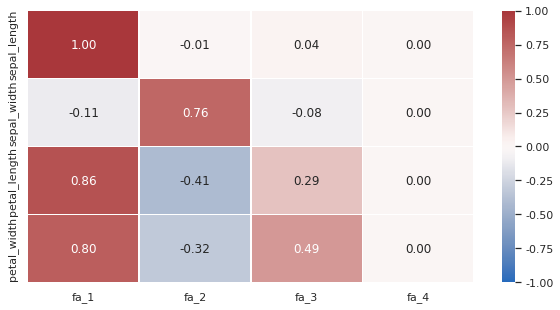

In [ ]:
sns.heatmap(
    data = loadings,
    annot = True,
    vmax = 1,
    vmin = -1,
    cmap = 'vlag', # 'RdYlBu_r', 'vlag', 'coolwarm'
    linewidths=.5,
    fmt='.2f',
    );

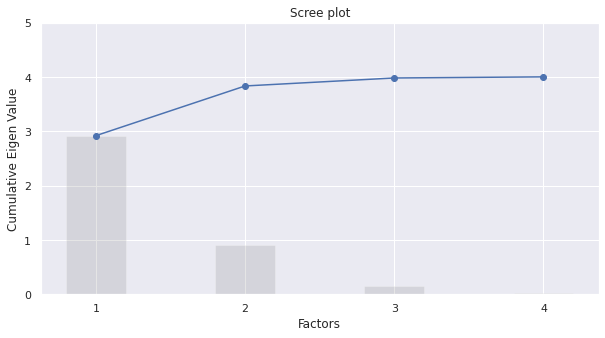

In [ ]:
x = range(1, ncomp+1)
y = ev
s = cev

plt.title('Scree plot'.format(ncomp))
plt.ylim(0, ncomp+1)
plt.xticks(x)
plt.xlabel('Factors')
plt.ylabel('Cumulative Eigen Value')

plt.bar(x, y, color='grey', width=0.4, alpha=0.2)
plt.plot(x, s, 'bo-')

plt.show()

In [ ]:
# 요인의 갯수를 결정하고
ncomp = 3
fa = FactorAnalyzer(n_factors=ncomp, rotation='varimax')
fa_comp = fa.fit_transform(df)

loadings = pd.DataFrame(
    data=fa.loadings_, 
    index=df.columns,
    columns=[ 'fa_'+ str(i+1) for i in range(ncomp) ]
    )

> 요인분석 결과 검증
- 크론바흐 알파: 주어진 변수들이 한개 그룹에 속할 수 있는지 내적일관성 측정, 0.7 이상이면 우수

In [ ]:
import pingouin as pg

# 요인별로 크론바흐 알파값을 계산
for c in loadings.columns:
    idx = loadings[c].loc[np.abs(loadings[c]) >= 0.3].index

    # 적어도 변수가 2개 이상이어야 크론바흐 알파 값 계산 가능
    if len(idx) >= 2:
        factor_alpha, conf_interval = pg.cronbach_alpha(df[idx])
        print(f'{c} : {factor_alpha}')

fa_1 : 0.8771447836441384
fa_2 : 0.4542665948543568


# ◈ 데이터 샘플링

In [ ]:
df = pd.DataFrame(data = { 'y' : np.random.randint(0, 3, 1000), 'x1' : np.random.randn(1000), 'x2' : np.random.randn(1000)})
df.y = df.y.replace(2, 1)
print(df.y.value_counts())

1    664
0    336
Name: y, dtype: int64


## 1) Random Sampling

In [ ]:
np.random.seed(10)
np.random.choice(df.x1, 30, replace=True)

array([ 0.65065402,  0.30204768,  0.17660407, -1.89065118, -1.89478014,
       -1.70741181, -1.22227907,  1.30698609, -0.99267896, -1.60382914,
       -0.35031591, -0.97487957, -0.96871919,  0.40164675, -0.38313444,
        0.02622722,  0.44021904,  0.32579748, -0.24656457, -0.09530852,
       -0.50509294, -0.56488378, -0.67975724, -1.3393527 , -2.08686391,
        0.13016151, -1.53735216,  0.03768862, -1.05237993,  1.14374978])

## 2) Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

df_rus, y = RandomUnderSampler().fit_resample(df[['x1', 'x2']], df.y)
df_rus['y'] = y

print(df_rus.y.value_counts())

0    336
1    336
Name: y, dtype: int64


## 3) Over Sampling

> Random Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

df_ros, y = RandomOverSampler().fit_resample(df[['x1', 'x2']], df.y)
df_ros['y'] = y

print(df_ros.y.value_counts())

0    664
1    664
Name: y, dtype: int64


> SMOTE Over Sampling

In [ ]:
from imblearn.over_sampling import SMOTE

df_smote, y = SMOTE().fit_resample(df[['x1', 'x2']], df.y)
df_smote['y'] = y

print(df_smote.y.value_counts())

0    664
1    664
Name: y, dtype: int64
